# Tutorial on Gradient Explanations

#### [1] Import relevant packages

In [1]:
import untangle

In [2]:
from torchvision import models
import numpy as np
import torch
from torchvision import transforms
import PIL
import os
from IPython.display import Image
from untangle import UntangleAI
untangle_ai = UntangleAI() # load and define our package api

#### [2] Define configurable parameters, setup IO paths and execution devices (CPU/GPU)

In [3]:
class Args:
    mname = 'vgg19'
    img_size = (3,224,224) # a 3-tuple of (CHW)
    num_classes = 1000
    method = 'vanillaGrad' # one of `vanillaGrad`, `deConvNet`, `guided_bp`, `gradcam`, `saliencyGrad`, `integratedGrad` `smoothgrad`
    topk = 5
    cmap = 'seismic'
    json = False
    hm_diff = 'joint'

    target_layer_idx = ["35"] # only for gradcam

    steps = 50 # only for integrated gradients
    baseline = None # torch tensor (of shape `input_tensor`) only for integrated gradients

    base_method = 'guided_bp' # only for smooth grad
    stdev_spread = 0.25 # only for smooth grad
    nsamples = 25 # only for smooth grad
    magnitude = True # only for smooth grad

args = Args()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
module_path = os.path.realpath('.')
results_path = os.path.join(module_path, 'baseline_results')
if(not os.path.exists(results_path)):
    os.makedirs(results_path)
out_prefix = os.path.join(results_path, '{}_{}'.format(args.mname, args.method))

#### [3] Define your torch model and the input to get visual explanation for

For the explanation APIs to work, we require (i) true input tensor of shape `HWC` (one of torch tensor, ndArray or PIL Image object), and (ii) the transformed input tensor of shape `BCHW` that is fed as input to the model

Utility function to load and transform an image that needs to be visualized. Please ensure same transformations are applied to this test image, which was used for training the model.

In [4]:
def load_adHoc_image(img_path, img_size=(224,224,3)):
    img_transform = transforms.Compose([
        transforms.Resize((img_size[0]+32, img_size[1]+32)),
        transforms.CenterCrop((img_size[0], img_size[1])),
    ])
    tensor_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    if(not os.path.exists(img_path)):
        raise FileNotFoundError(img_path)
    inp_image = PIL.Image.open(img_path)
    inp_image = inp_image.convert("RGB")
    crop_inp_image = img_transform(inp_image)
    input_tensor = tensor_transform(crop_inp_image)
    input_tensor = input_tensor.unsqueeze(0)
    if (torch.cuda.is_available()):
        input_tensor = input_tensor.cuda()
    return(input_tensor, crop_inp_image)

In [5]:
model = models.vgg19(pretrained=True)
model = model.to(DEVICE)
model.eval()
img_path = 'Scuba_Shark.JPEG'
input_tensor, input_img = load_adHoc_image(img_path)
input_tensor = input_tensor.to(DEVICE)
input_img = np.asarray(input_img)

#### [4.1] Vanilla Gradient Explanation

Let the gradient of output prediction, $O_k \in \textit{class-k}$ w.r.t the input $\textbf{X}_i$ be given by: $\nabla_{\textbf{X}_i} O_k$.
This gradient helps in understanding how the change in each input pixel intensity affects the target prediction.

The `vanillaGrad()` function computes this gradient and the heatmaps for top-k predictions. The heatmaps are computed for each of the top-k classes as follows:
* [a]. Heatmap for each class - A heatmap is computed on the gradient of a specified output class w.r.t the input


* [b]. Difference heatmaps - We want to understand strength of gradients of the top class (`class_0`) $\textit{relative}$ to the gradient of `class_1`, `class_2`, ... `class_k` as follows:
    * difference of input gradients of `class_0` and `class_1` i.e., heatmap($ \textit{Max}\{ (\nabla_{\textbf{X}_i} O_0 - \nabla_{\textbf{X}_i} O_1), 0\}$)
    * difference of input gradients of `class_0` and `class_2` i.e., heatmap($ \textit{Max}\{ (\nabla_{\textbf{X}_i} O_0 - \nabla_{\textbf{X}_i} O_2), 0\}$)
    * difference of input gradients of `class_0` and `class_k` i.e., heatmap($ \textit{Max}\{ (\nabla_{\textbf{X}_i} O_0 - \nabla_{\textbf{X}_i} O_k), 0\}$)


* [c]. Inverse Difference heatmaps - We want to understand strength of gradients of prediction classes w.r.t the top prediction as follows:
    * difference of input gradients of `class_1` and `class_0` i.e., heatmap($ \textit{Max}\{ (\nabla_{\textbf{X}_i} O_1 - \nabla_{\textbf{X}_i} O_0), 0\}$)
    * difference of input gradients of `class_2` and `class_0` i.e., heatmap($ \textit{Max}\{ (\nabla_{\textbf{X}_i} O_2 - \nabla_{\textbf{X}_i} O_0), 0\}$)
    * difference of input gradients of `class_k` and `class_0` i.e., heatmap($ \textit{Max}\{ (\nabla_{\textbf{X}_i} O_k - \nabla_{\textbf{X}_i} O_0), 0\}$)
    
Following naming convention is used to save heatmaps: `modelName_methodName_class_k.JPEG` where `class_0` refers to the top prediction and `class_k` refers to the `k-th` top prediction 

In [6]:
untangle_ai.vanillaGrad(model, input_tensor, input_img, out_prefix, args)

Top-5 class(es): ['2', '3', '4', '983', '148']
Top-5 logit(s): [23.066195, 20.449593, 18.065945, 17.856592, 16.999245]
Top-5 probs(s): [0.91761494, 0.06703239, 0.006181296, 0.0050137066, 0.0021272458]
class_0 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_vanillaGrad_class_0.JPEG`
class_1 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_vanillaGrad_class_1.JPEG`
class_2 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_vanillaGrad_class_2.JPEG`
class_3 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_vanillaGrad_class_3.JPEG`
class_4 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_vanillaGrad_class_4.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_vanillaGrad_diff_class_1.JPEG`
class_2 specific diff heatmap saved in path: `/Users/harsha/dev

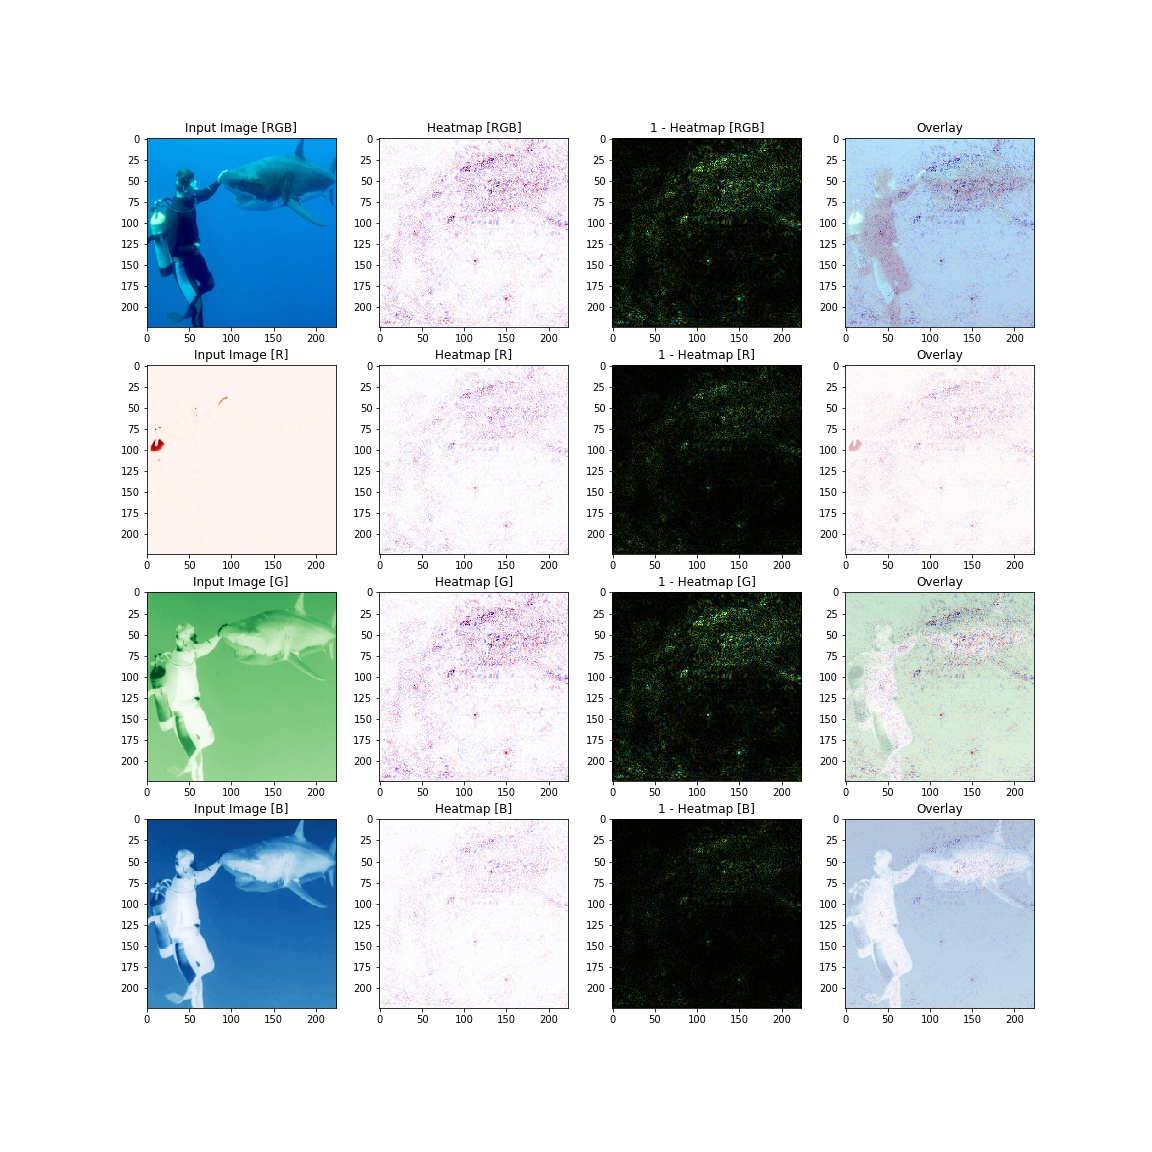

In [7]:
Image("baseline_results/vgg19_vanillaGrad_class_0.JPEG")

#### [4.2] DeConvNet
[DeConvNet](https://arxiv.org/abs/1311.2901) inverts the data flow from higher feature maps back to the input image. Specifically, given a non-zero neuron at a higher layer, inverting the data flow shows parts of the input image that most strongly activate this neuron.

In [8]:
model = models.vgg19(pretrained=True)
model = model.to(DEVICE)
img_path = 'Scuba_Shark.JPEG'
input_tensor, input_img = load_adHoc_image(img_path)
input_tensor = input_tensor.to(DEVICE)
input_img = np.asarray(input_img)

args.method = 'deConvNet'
out_prefix = os.path.join(results_path, '{}_{}'.format(args.mname, args.method))
untangle_ai.deConvNet(model, input_tensor, input_img, out_prefix, args)

Top-5 class(es): ['2', '3', '4', '983', '148']
Top-5 logit(s): [23.066195, 20.449593, 18.065945, 17.856592, 16.999245]
Top-5 probs(s): [0.91761494, 0.06703239, 0.006181296, 0.0050137066, 0.0021272458]
class_0 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_deConvNet_class_0.JPEG`
class_1 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_deConvNet_class_1.JPEG`
class_2 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_deConvNet_class_2.JPEG`
class_3 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_deConvNet_class_3.JPEG`
class_4 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_deConvNet_class_4.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_deConvNet_diff_class_1.JPEG`
class_2 specific diff heatmap saved in path: `/Users/harsha/dev/example/bas

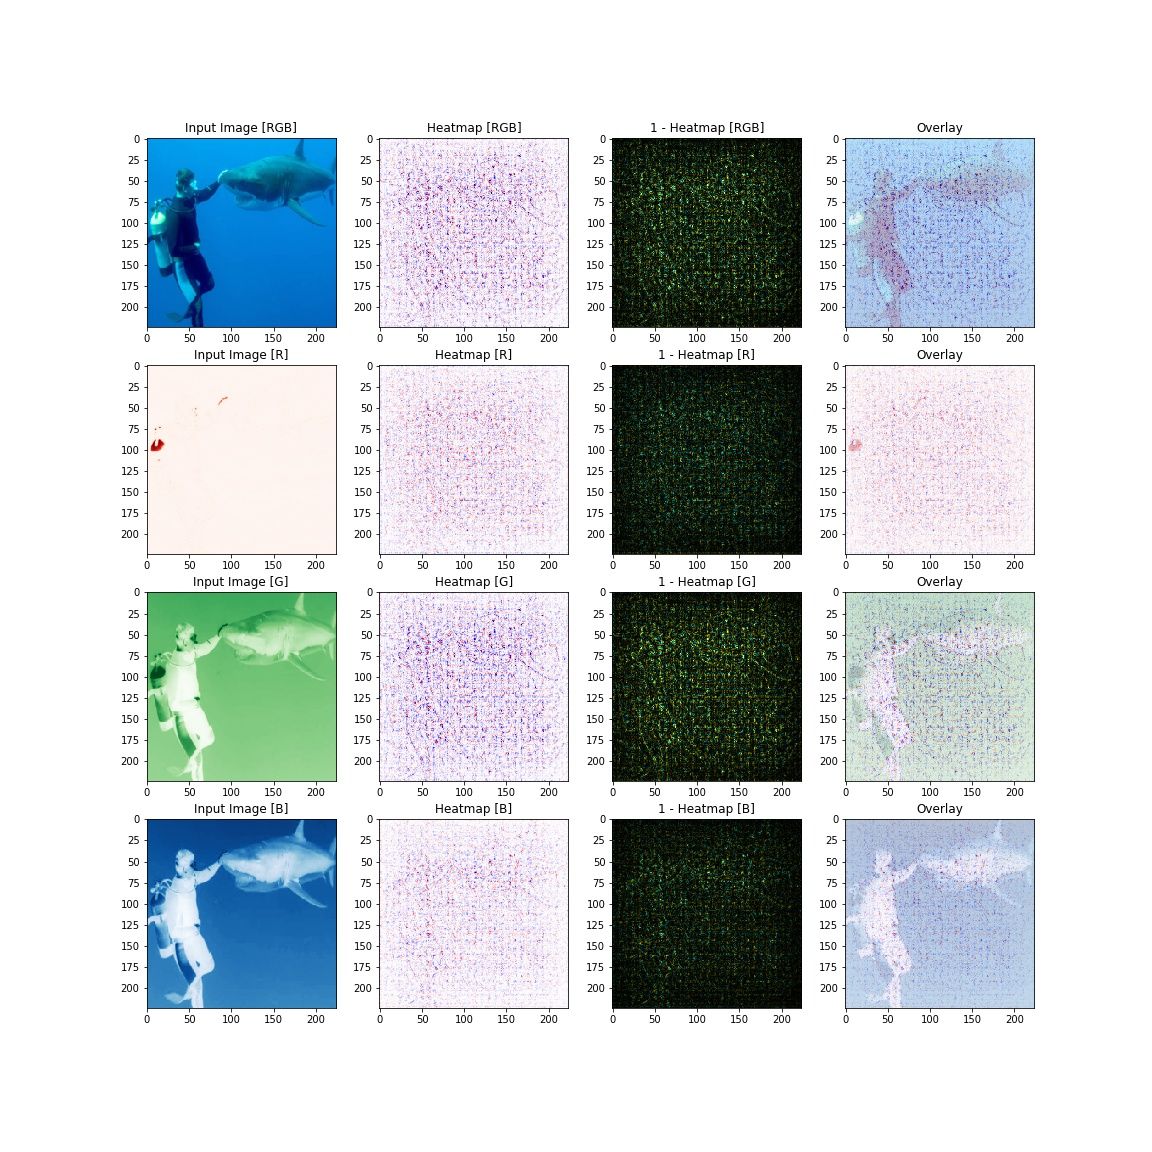

In [9]:
Image("baseline_results/vgg19_deConvNet_class_0.JPEG")

#### [4.3] Guided Backprop

[Guided BackProp](https://arxiv.org/abs/1412.6806) builds on [DeConvNet](https://arxiv.org/abs/1311.2901) explanation method where negative gradients are set to zero while backpropagating through a ReLu input. 

In [10]:
model = models.vgg19(pretrained=True)
model = model.to(DEVICE)
img_path = 'Scuba_Shark.JPEG'
input_tensor, input_img = load_adHoc_image(img_path)
input_tensor = input_tensor.to(DEVICE)
input_img = np.asarray(input_img)

args.method = 'guided_bp'
out_prefix = os.path.join(results_path, '{}_{}'.format(args.mname, args.method))
untangle_ai.guided_bp(model, input_tensor, input_img, out_prefix, args)

Top-5 class(es): ['2', '3', '4', '983', '148']
Top-5 logit(s): [23.066195, 20.449593, 18.065945, 17.856592, 16.999245]
Top-5 probs(s): [0.91761494, 0.06703239, 0.006181296, 0.0050137066, 0.0021272458]
class_0 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_guided_bp_class_0.JPEG`
class_1 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_guided_bp_class_1.JPEG`
class_2 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_guided_bp_class_2.JPEG`
class_3 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_guided_bp_class_3.JPEG`
class_4 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_guided_bp_class_4.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_guided_bp_diff_class_1.JPEG`
class_2 specific diff heatmap saved in path: `/Users/harsha/dev/example/bas

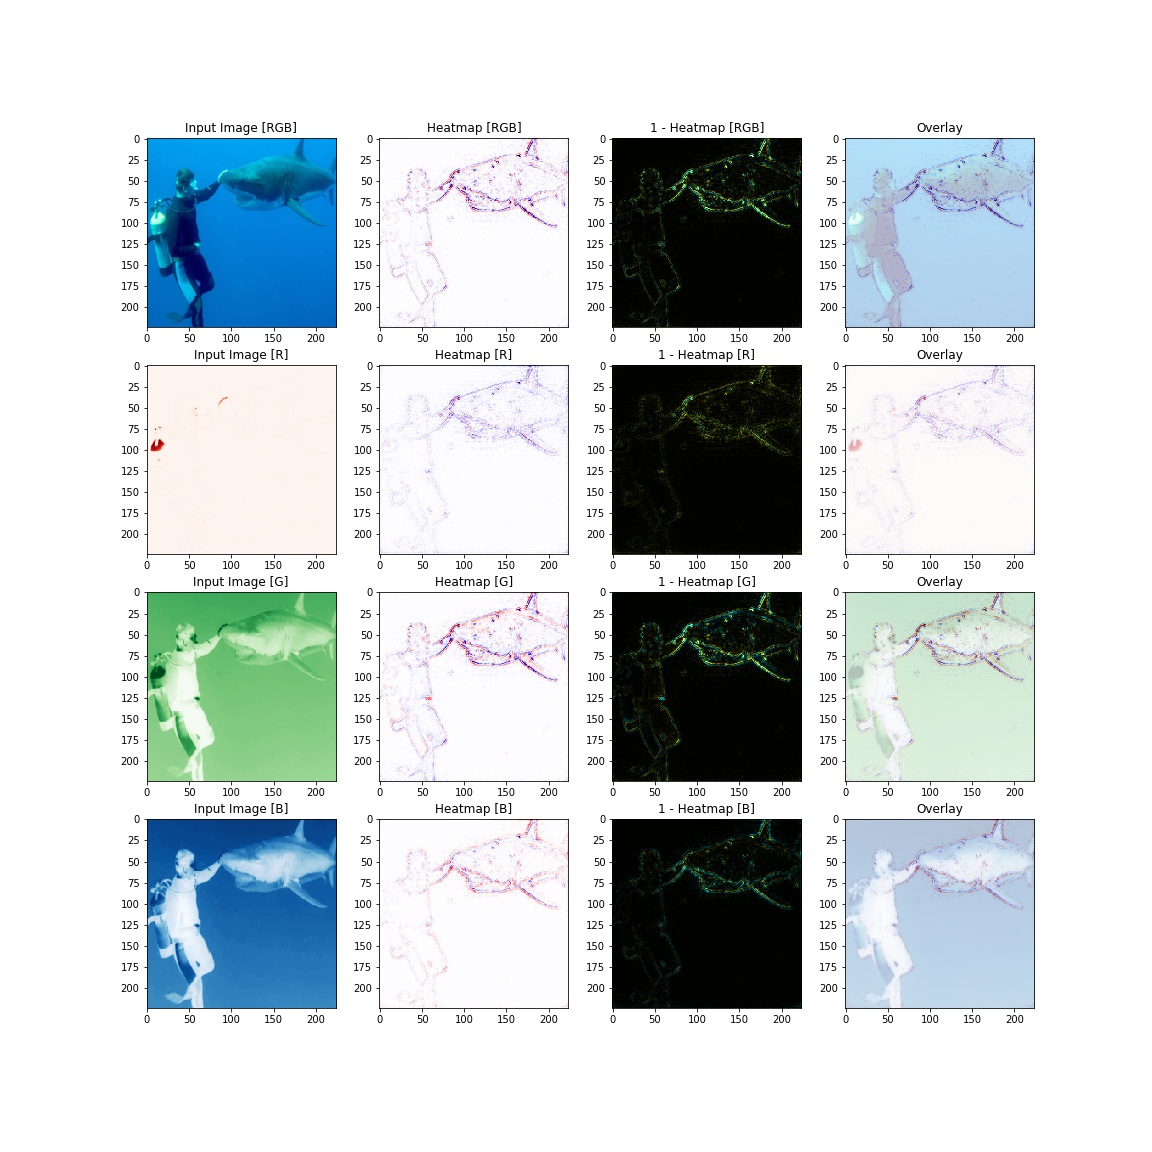

In [11]:
Image("baseline_results/vgg19_guided_bp_class_0.JPEG")

#### [4.4] GradCAM

[GradCAM](https://arxiv.org/abs/1610.02391) explanations correspond to the gradient of the class score (logit) with respect to the feature map of the last convolutional unit of a DNN. This gradient signal is then resized to the original input dimension usng suitagle interpolation technique.

In [12]:
model = models.vgg19(pretrained=True)
model = model.to(DEVICE)
img_path = 'Scuba_Shark.JPEG'
input_tensor, input_img = load_adHoc_image(img_path)
input_tensor = input_tensor.to(DEVICE)
input_img = np.asarray(input_img)

args.method = 'gradcam'
out_prefix = os.path.join(results_path, '{}_{}'.format(args.mname, args.method))
untangle_ai.gradcam(model, input_tensor, input_img, out_prefix, args)

Top-5 class(es): ['2', '3', '4', '983', '148']
Top-5 logit(s): [23.066195, 20.449593, 18.065945, 17.856592, 16.999245]
Top-5 probs(s): [0.91761494, 0.06703239, 0.006181296, 0.0050137066, 0.0021272458]
class_0 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_gradcam_class_0.JPEG`
class_1 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_gradcam_class_1.JPEG`
class_2 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_gradcam_class_2.JPEG`
class_3 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_gradcam_class_3.JPEG`
class_4 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_gradcam_class_4.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_gradcam_diff_class_1.JPEG`
class_2 specific diff heatmap saved in path: `/Users/harsha/dev/example/baseline_result

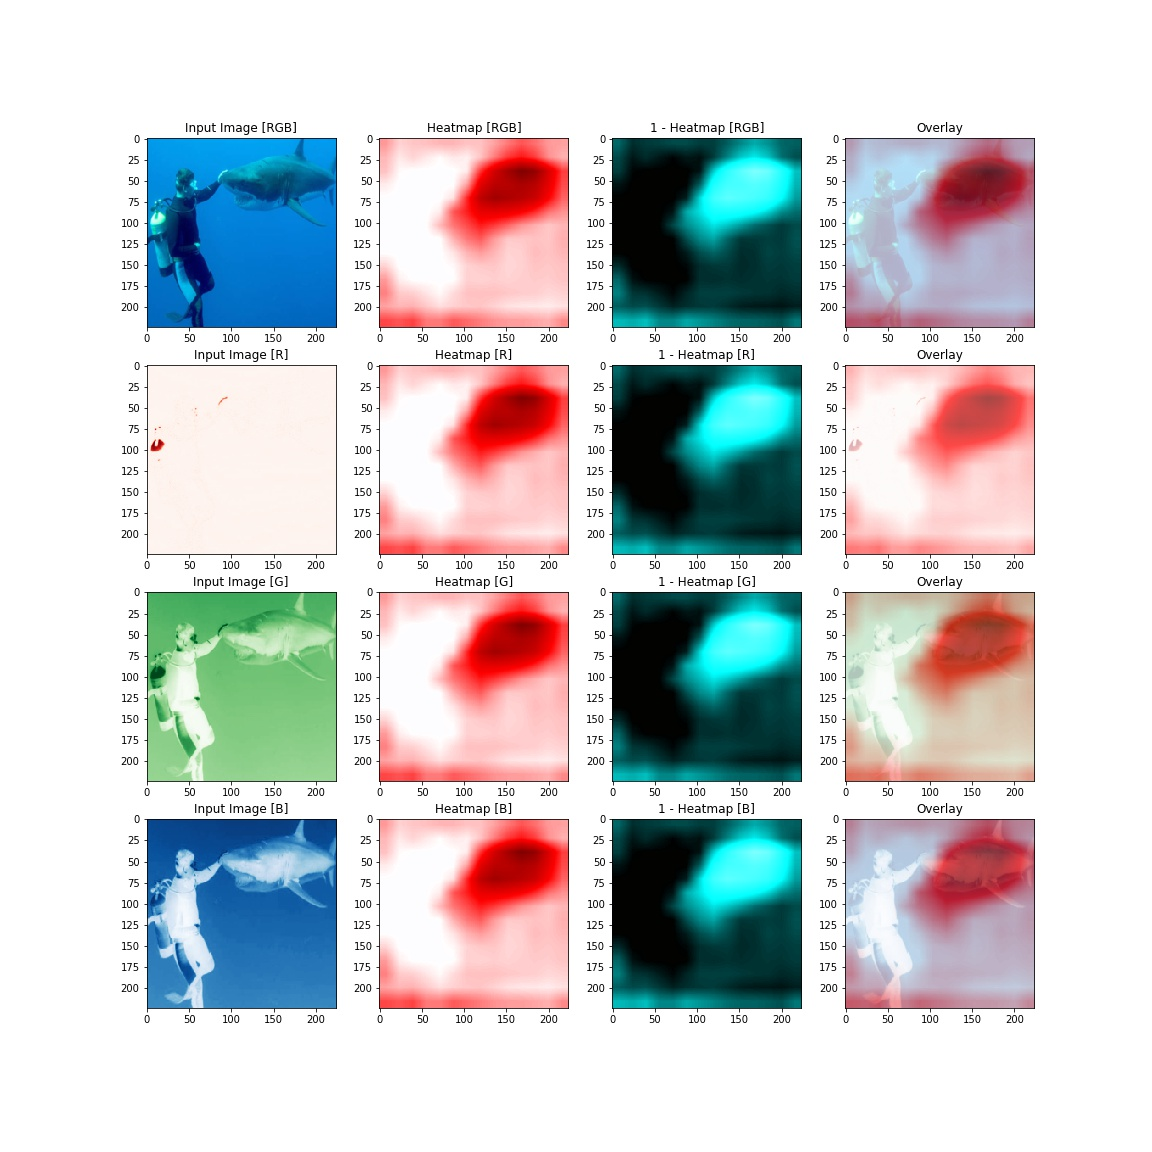

In [13]:
Image("baseline_results/vgg19_gradcam_class_0.JPEG")

#### [4.5] saliencyGrad

Saliency Grad is defined as the absolute value of the gradient of class prediction w.r.t the input

In [14]:
model = models.vgg19(pretrained=True)
model = model.to(DEVICE)
img_path = 'Scuba_Shark.JPEG'
input_tensor, input_img = load_adHoc_image(img_path)
input_tensor = input_tensor.to(DEVICE)
input_img = np.asarray(input_img)

args.method = 'saliencyGrad'
out_prefix = os.path.join(results_path, '{}_{}'.format(args.mname, args.method))
untangle_ai.saliencyGrad(model, input_tensor, input_img, out_prefix, args)

Top-5 class(es): ['2', '3', '4', '983', '148']
Top-5 logit(s): [23.066195, 20.449593, 18.065945, 17.856592, 16.999245]
Top-5 probs(s): [0.91761494, 0.06703239, 0.006181296, 0.0050137066, 0.0021272458]
class_0 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_saliencyGrad_class_0.JPEG`
class_1 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_saliencyGrad_class_1.JPEG`
class_2 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_saliencyGrad_class_2.JPEG`
class_3 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_saliencyGrad_class_3.JPEG`
class_4 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_saliencyGrad_class_4.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_saliencyGrad_diff_class_1.JPEG`
class_2 specific diff heatmap saved in path: `/Users/hars

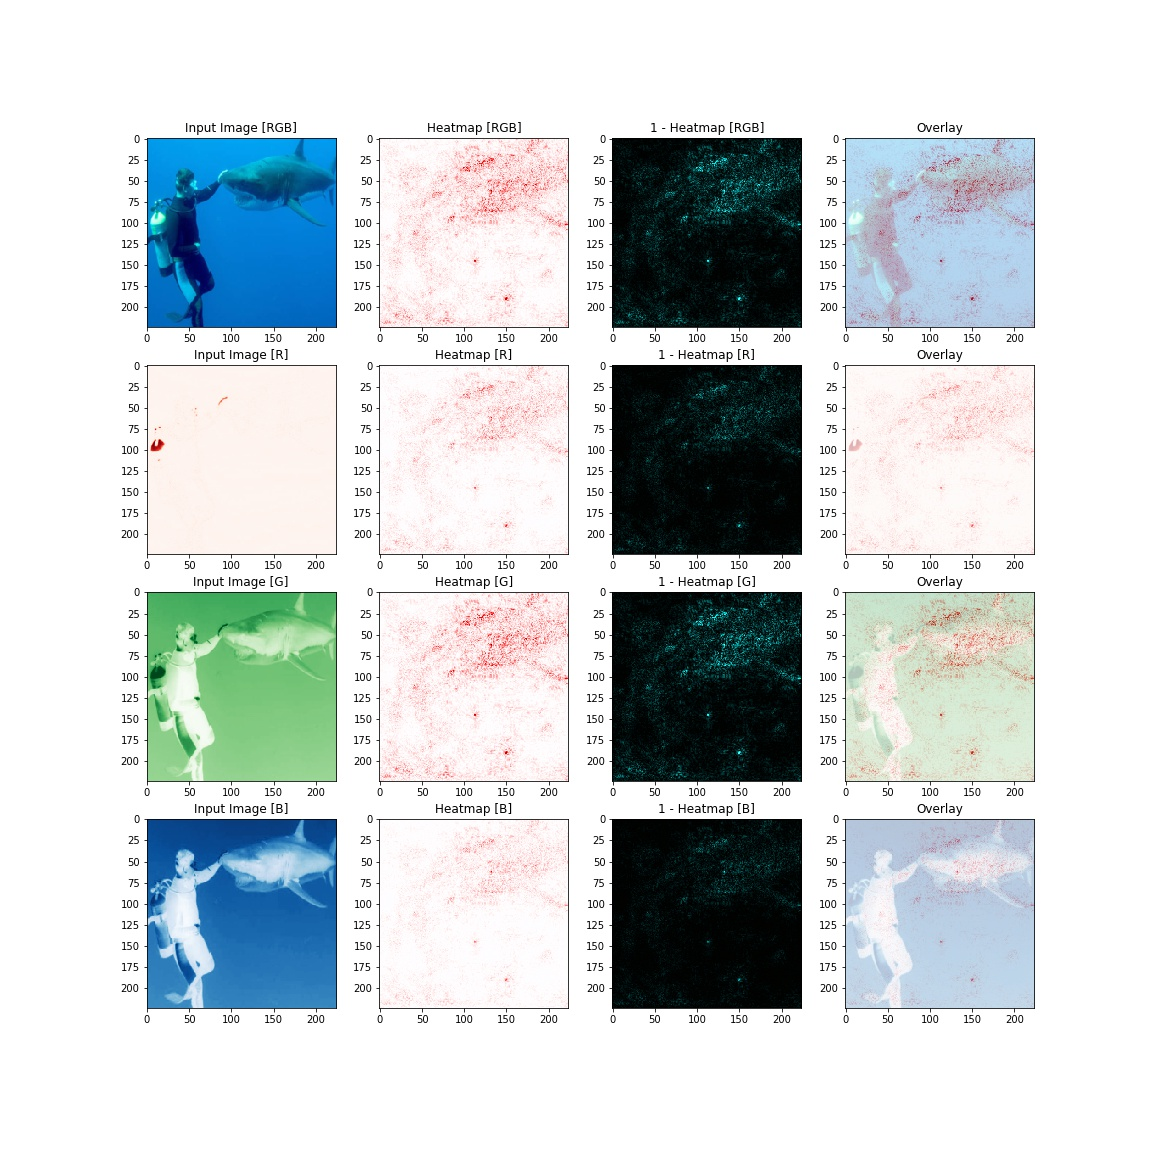

In [15]:
Image("baseline_results/vgg19_saliencyGrad_class_0.JPEG")

#### [4.5] integratedGrad

[Integrated Gradients](https://arxiv.org/abs/1703.01365), $IG(x)$ for a given input $x$ helps in reducing the saturation in gradients by summing over scaled version of the input.

$$IG(x_i) = x_i - (x_0)_i * \int_{\alpha=0}^{1} \frac{\partial F( (x_0)_i + \alpha * (x_i - (x_0)_i)  )}{\partial x_i} \textit{d}\alpha  $$

In [16]:
model = models.vgg19(pretrained=True)
model = model.to(DEVICE)
img_path = 'Scuba_Shark.JPEG'
input_tensor, input_img = load_adHoc_image(img_path)
input_tensor = input_tensor.to(DEVICE)
input_img = np.asarray(input_img)

args.method = 'integratedGrad'
out_prefix = os.path.join(results_path, '{}_{}'.format(args.mname, args.method))
untangle_ai.integratedGrad(model, input_tensor, input_img, out_prefix, args)

Top-5 class(es): ['2', '3', '4', '983', '148']
Top-5 logit(s): [23.066195, 20.449593, 18.065945, 17.856592, 16.999245]
Top-5 probs(s): [0.91761494, 0.06703239, 0.006181296, 0.0050137066, 0.0021272458]
class_0 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_integratedGrad_class_0.JPEG`
class_1 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_integratedGrad_class_1.JPEG`
class_2 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_integratedGrad_class_2.JPEG`
class_3 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_integratedGrad_class_3.JPEG`
class_4 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_integratedGrad_class_4.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_integratedGrad_diff_class_1.JPEG`
class_2 specific diff heatmap saved in path: 

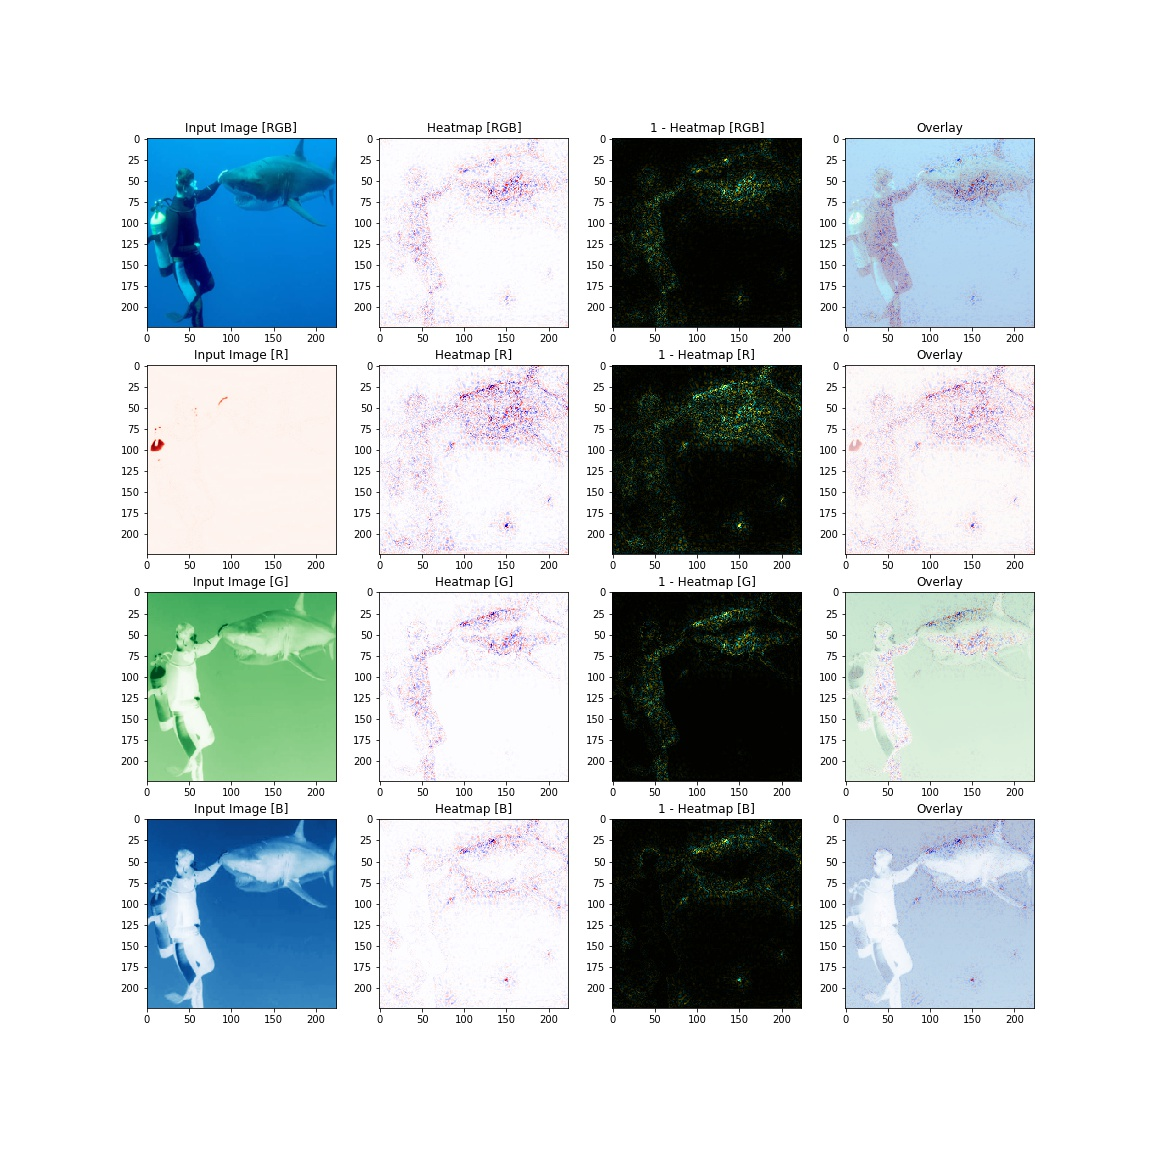

In [17]:
Image("baseline_results/vgg19_integratedGrad_class_0.JPEG")

#### [4.5] SmoothGrad on Guided Backprop

[SmoothGrad](https://arxiv.org/pdf/1706.03825.pdf) is a meta algorithm that sits on top of a given gradient explanation method. It tries to suppress noise in the gradients by averaging gradients across multiple noisy versions of the input. For a given input $\pmb{x}$, the smoothGrad gradient, $SG(\pmb{x})$ is given by:

$$SG(\pmb{x}) = \sum_{i=1}^n \nabla_{\pmb{x} + g_i} O_k$$ where $\pmb{g}_i \sim \mathcal{N}(\mu,\sigma^2)$ are drawn i.i.d from a Normal distribution.

In [18]:
model = models.vgg19(pretrained=True)
model = model.to(DEVICE)
img_path = 'Scuba_Shark.JPEG'
input_tensor, input_img = load_adHoc_image(img_path)
input_tensor = input_tensor.to(DEVICE)
input_img = np.asarray(input_img)

args.method = 'smoothgrad'
args.base_method = 'guided_bp'
args.nsamples = 10 
out_prefix = os.path.join(results_path, '{}_{}_{}'.format(args.mname, args.base_method, args.method))
base_explainer = untangle_ai.get_explainer(args.base_method, model, args)
untangle_ai.smoothgrad(model, base_explainer, input_tensor, input_img, out_prefix, args)

Top-5 class(es): ['2', '3', '4', '983', '148']
Top-5 logit(s): [23.066195, 20.449593, 18.065945, 17.856592, 16.999245]
Top-5 probs(s): [0.91761494, 0.06703239, 0.006181296, 0.0050137066, 0.0021272458]
class_0 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_guided_bp_smoothgrad_class_0.JPEG`
class_1 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_guided_bp_smoothgrad_class_1.JPEG`
class_2 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_guided_bp_smoothgrad_class_2.JPEG`
class_3 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_guided_bp_smoothgrad_class_3.JPEG`
class_4 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_guided_bp_smoothgrad_class_4.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_guided_bp_smoothgrad_diff_class_1.JPEG`
class_2 s

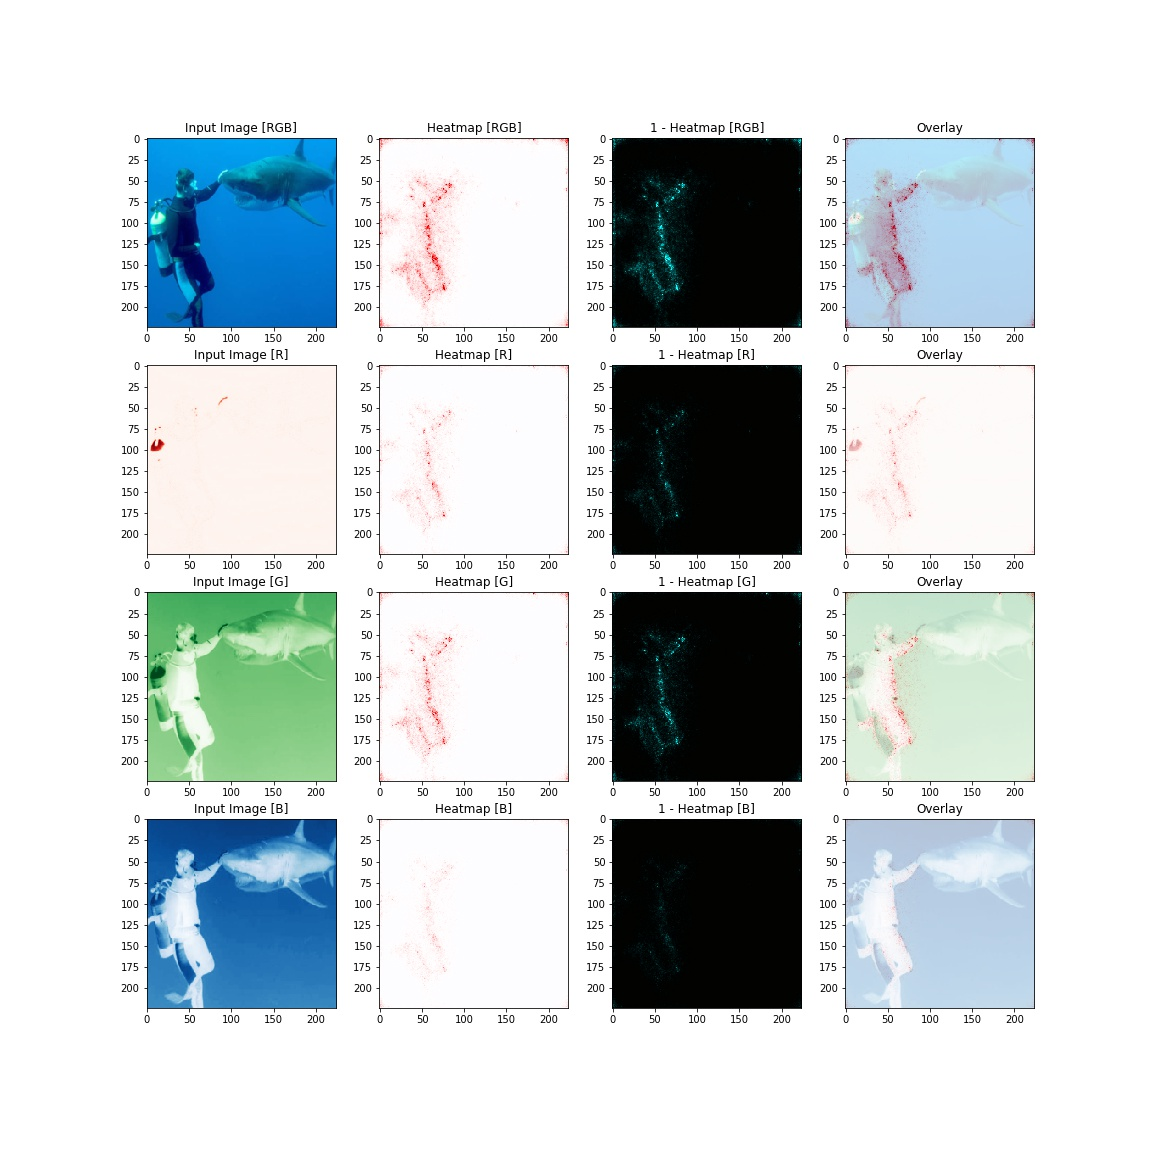

In [19]:
Image('baseline_results/vgg19_guided_bp_smoothgrad_class_0.JPEG')

#### [4.6] SmoothGrad on Integratedgrad

In [20]:
model = models.vgg19(pretrained=True)
model = model.to(DEVICE)
img_path = 'Scuba_Shark.JPEG'
input_tensor, input_img = load_adHoc_image(img_path)
input_tensor = input_tensor.to(DEVICE)
input_img = np.asarray(input_img)

args.method = 'smoothgrad'
args.base_method = 'integratedGrad'
stdev_spread = 0.05
nsamples = 25
magnitude = False
    
out_prefix = os.path.join(results_path, '{}_{}_{}'.format(args.mname, args.base_method, args.method))
base_explainer = untangle_ai.get_explainer(args.base_method, model, args)
untangle_ai.smoothgrad(model, base_explainer, input_tensor, input_img, out_prefix, args)

Top-5 class(es): ['2', '3', '4', '983', '148']
Top-5 logit(s): [23.066195, 20.449593, 18.065945, 17.856592, 16.999245]
Top-5 probs(s): [0.91761494, 0.06703239, 0.006181296, 0.0050137066, 0.0021272458]
class_0 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_integratedGrad_smoothgrad_class_0.JPEG`
class_1 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_integratedGrad_smoothgrad_class_1.JPEG`
class_2 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_integratedGrad_smoothgrad_class_2.JPEG`
class_3 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_integratedGrad_smoothgrad_class_3.JPEG`
class_4 specific heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_integratedGrad_smoothgrad_class_4.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/Users/harsha/dev/example/baseline_results/vgg19_integratedGrad_smoothgra

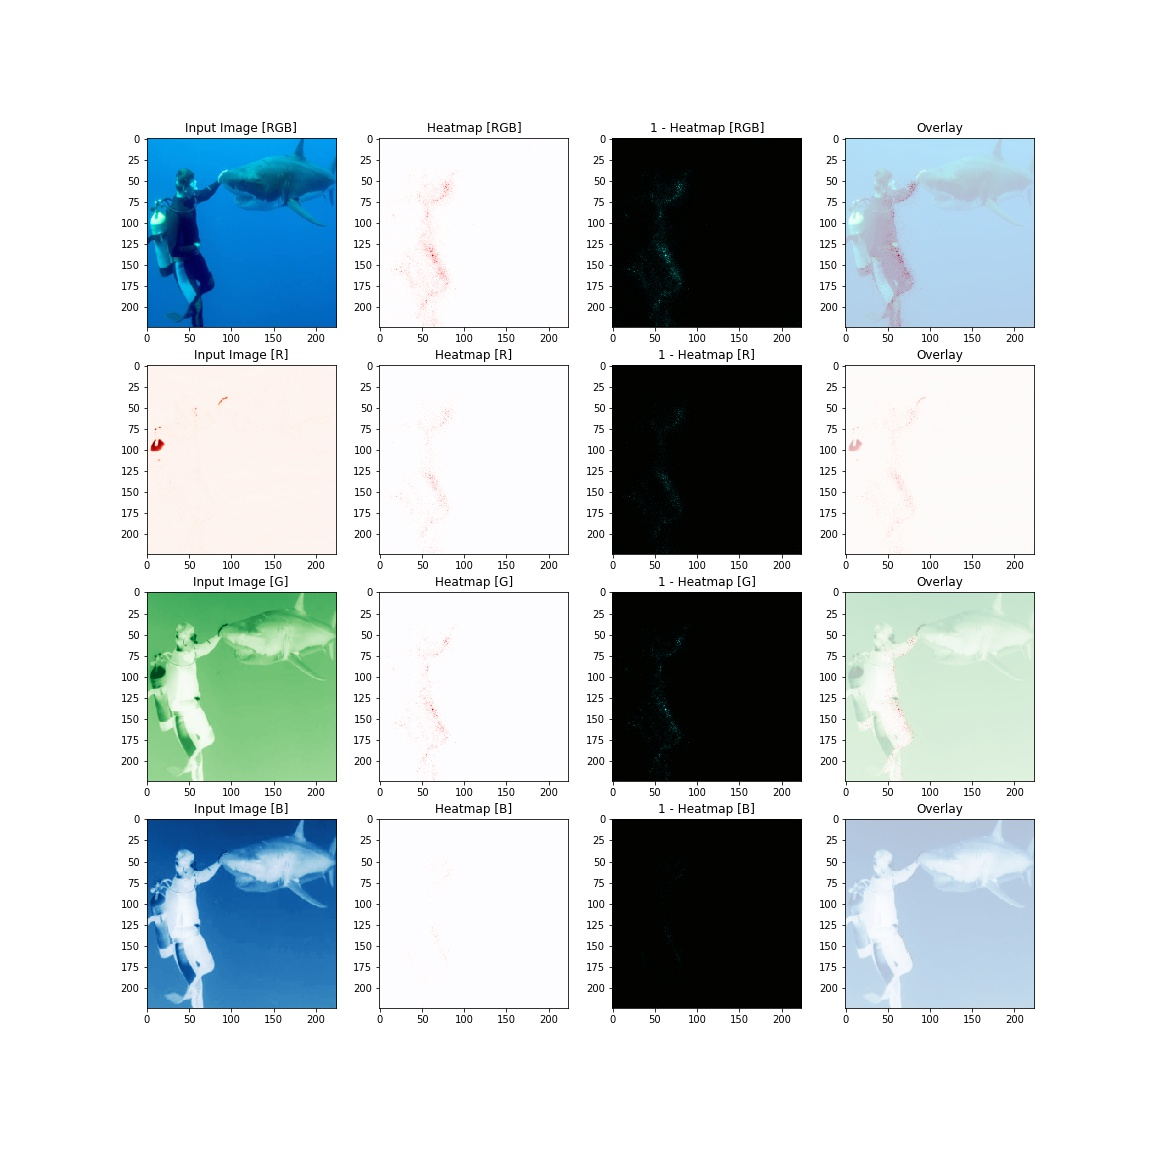

In [21]:
Image('baseline_results/vgg19_integratedGrad_smoothgrad_class_0.JPEG')